In [1]:
import tensorflow as tf
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns
from datetime import datetime
from tensorflow import keras

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm
from keras.preprocessing.image import ImageDataGenerator


In [2]:
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    resaved_file_name = 'resaved_image.jpg'    
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    ela_image = ImageChops.difference(original_image,resaved_image)
    
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 255 / max_difference
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [3]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0        

In [14]:
X = []
Y = []

In [15]:

path = os.path.join('D:', 'data_sets', 'general_image_tampering', 'CASIA', 'CASIA2', 'authentic')
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg'):
        try:
            full_path = os.path.join(path, filename)
            X.append(prepare_image(full_path))        
            Y.append(1)     
        except:
            pass

print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/7492 [00:00<?, ?it/s]

Total images: 7354
Total labels: 7354


In [16]:

path = os.path.join('D:', 'data_sets', 'general_image_tampering', 'CASIA', 'CASIA2', 'tampered')
i=0
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg') or filename.endswith('tif'):
            i+=1
            try:
                full_path = os.path.join(path, filename)
                X.append(prepare_image(full_path))        
                Y.append(0)    
            except:
                pass

# Só foram pegas 2064 imagens de um total de 5123
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images :   0%|          | 0/5123 [00:00<?, ?it/s]

Total images: 12477
Total labels: 12477


In [17]:
from sklearn.utils import shuffle



In [18]:
X = np.array(X)
Y = np.array(Y)
X,Y= shuffle(X,Y)

X = X.reshape(-1, 128, 128, 3)


# proposed_fidac_500
# casia_1
# casia_2
np.save(os.path.join('training_data', 'casia_2_x.npy'), X, allow_pickle=True)
np.save(os.path.join('training_data', 'casia_2_y.npy'), Y, allow_pickle=True)


In [2]:
X = np.load(os.path.join('training_data', 'casia_2_x.npy'), allow_pickle=True)
Y = np.load(os.path.join('training_data', 'casia_2_y.npy'), allow_pickle=True)

print(np.shape(X),np.shape(Y))

(12477, 128, 128, 3) (12477,)


In [3]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 9482 , Training labels: 9482
Validation images: 2371 , Validation labels: 2371
Test images: 624 , Test labels: 624


In [4]:
print(Y_test)

[0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1
 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1
 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0
 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0
 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0
 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1
 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0
 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 0 1 0 0 1 1 1 1 

In [5]:
train_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    #zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)
test_gen =  ImageDataGenerator()

train_gen.fit(X_train)
test_gen.fit(X_val)

augmented_data = []


In [6]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(256, (3,3), activation = 'relu'))
    model.add(Conv2D(256, (3,3), activation = 'relu', padding = "SAME"))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

# def build_model():
#     model = Sequential()
#     model.add(tf.keras.applications.ResNet101(input_shape=(128, 128, 3), include_top=False, weights='imagenet'))
#     model.add(Flatten())
#     model.add(Dense(1, activation = 'sigmoid'))
#     return model

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       1

In [8]:
epochs = 40
batch_size = 24
init_lr = 1e-4  
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = init_lr, decay = init_lr/epochs) 
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = [tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

In [9]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [10]:
hist = model.fit(train_gen.flow(X_train, Y_train, batch_size=19),
                 batch_size = batch_size,
                 epochs = epochs,
                 #steps_per_epoch = 14,
                 validation_data = train_gen.flow(X_train, Y_train, batch_size=19),
                 callbacks = [early_stopping])

Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.0023 - precision: 0.8056 - recall: 0.8391

In [43]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = f'models/IFAKE_ELA_VGG16_CASIA_1{timestamp}'
# model.save(os.path.join(path, 'model.h5')) 

# history_dict = hist.history
# json.dump(history_dict, open(os.path.join(path, 'model_history.json'), 'w'))

c:\Repositories\projects\my-projects\tensor-flow-test\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = f'models/IFAKE_ELA_VGG16_CASIA_1{timestamp}'
path = f'models/IFAKE_ELA_PROPOSED_CASIA_1'
model = load_model(os.path.join(path, 'model.h5'))
history_dict = json.load(open(os.path.join(path, 'model_history.json'), 'r'))

Text(0.5, 0.98, 'Metrics')

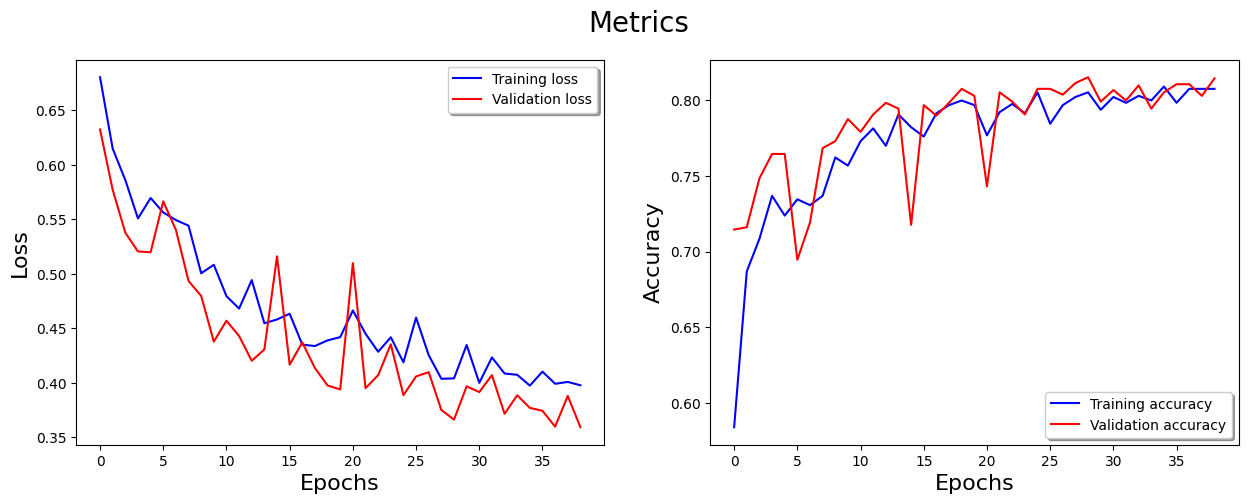

In [6]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(history_dict['loss'], color='b', label = "Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label = "Validation loss")
ax[0].set_xlabel('Epochs',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_dict['accuracy'], color='b', label = "Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r',label = "Validation accuracy")
ax[1].set_xlabel('Epochs',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)
legend = ax[1].legend(loc='best', shadow=True)

fig.suptitle('Metrics',fontsize=20)

In [7]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    print(group_counts)
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    print(group_percentages)

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plt.xlabel('Predicted labels', fontsize = 13)
    plt.ylabel('True labels', fontsize = 13)
    plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

    plt.show()

11/11 [==============================] - 2s 109ms/step
['149', '34', '54', '88']
['45.85%', '10.46%', '16.62%', '27.08%']


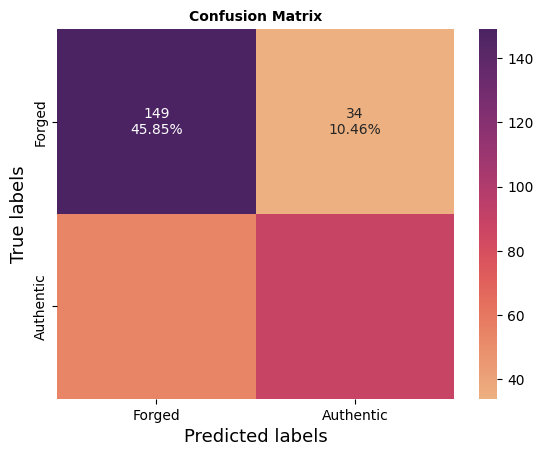

In [8]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.round(Y_pred)
Y_true = Y_val

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     
plot_confusion_matrix(confusion_mtx)                         


In [9]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       183
           1       0.72      0.62      0.67       142

    accuracy                           0.73       325
   macro avg       0.73      0.72      0.72       325
weighted avg       0.73      0.73      0.73       325



In [10]:
class_names = ['Forged', 'Authentic']

In [11]:
correct_test = 0
total_test = 0  
pred = []
for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    pred.append(y_pred)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: 
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %\n')

Processing Images :   0%|          | 0/86 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step
Total test images: 86
Correctly predicted images: 66
Accuracy: 76.74418604651163 %



In [21]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
fake_image = '../Datasets/TEST/Tp/'
correct = 0
total = 0
for file_name in os.listdir(fake_image):
    if file_name.endswith('jpg') or file_name.endswith('png'):
        test_image_path = os.path.join(fake_image, file_name)
        test_image = prepare_image(test_image_path)  
        test_image=test_image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(test_image)
        y_pred_class = round(y_pred[0][0])
        total += 1
        if y_pred_class == 0:
            correct += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: '../Datasets/TEST/Tp/'

In [ ]:
real_image = '../Datasets/Test/Au/'
correct_r = 0
total_r = 0
for file_name in os.listdir(real_image):
    if file_name.endswith('jpg') or file_name.endswith('png'):
        test_image_path = os.path.join(real_image, file_name)
        test_image = prepare_image(test_image_path)  
        test_image=test_image.reshape(-1, 128, 128, 3) 
        y_pred = model.predict(test_image)
        y_pred_class = round(y_pred[0][0])
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')

Class: Authentic Confidence: 99.84
Class: Authentic Confidence: 99.84
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.93
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 99.99
Class: Authentic Confidence: 99.69
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 96.89
Class: Authentic Confidence: 99.73
Class: Authentic Confidence: 99.57
Class: Authentic Confidence: 99.86
Class: Authentic Confidence: 99.26
Class: Authentic Confidence: 88.27
Class: Authentic Confidence: 67.10
Class: Authentic Confidence: 70.39
Class: Authentic Confidence: 99.86
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 100.00
Class: Authentic Confidence: 82.61
Class: Authentic Confidence: 96.75
Class: Authentic Confidence: 97.38
Class: Authentic Confidence: 95.78
Class: Authentic Confidence: 98.61
Class: Authentic Confidence: 80.73
Class: Authe

In [ ]:
correct += correct_r
total += total_r
#print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 99, Correct: 84, Acc: 84.84848484848484


In [ ]:
# test_image_path = '../casia2/test/1.JPG'    # test image path
# test_image = prepare_image(test_image_path)
# test_image = test_image.reshape(-1, 128, 128, 3)

# y_pred = model.predict(test_image)
# y_pred_class = int(round(y_pred[0][0]))

# fig, ax = plt.subplots(1,2,figsize=(15,5)) 

# original_image = plt.imread(test_image_path) 
# ax[0].axis('off')
# ax[0].imshow(original_image)
# ax[0].set_title('Original Image')

# ax[1].axis('off')
# ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
# ax[1].set_title('ELA Image')

# print(f'Prediction: {class_names[y_pred_class]}')
# if y_pred<=0.5:
#     print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
# else:
#     print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
# print('--------------------------------------------------------------------------------------------------------------')

In [ ]:
# test_folder_path = 'Datasets/FIDAC/Au/'        #dataset path
# authentic,forged,total = 0,0,0

# for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
#     #print(filename)
#     if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('jpeg') or filename.endswith('JPG'):
#         test_image_path = os.path.join(test_folder_path, filename)
#         test_image = prepare_image(test_image_path)  
#         test_image=test_image.reshape(-1, 128, 128, 3)
#         #y_pred = model.predict(image)
#         #y_pred_class = np.round(y_pred)
        
#         y_pred = model.predict(test_image)
#         y_pred_class = round(y_pred[0][0])

#         total += 1
#         #print('---',y_pred_class)
#         if y_pred_class == 0:
#             forged += 1
#         else:
#             authentic +=1

# print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

Processing Images :   0%|          | 0/14 [00:00<?, ?it/s]

Total images: 14
Authentic Images: 14
Forged Images: 0
